## pyfkpt + CAMB: 1-loop RSD multipoles

In [1]:
# ---- imports (standard packages) ----
import os, tempfile
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

# ---- pyfkpt (new fkpt wrapper) ----
import pyfkpt.rsd as pyfkpt
    
# ---- ISiTGR: linear matter P(k) and f at z_pk ----
import isitgr
from isitgr import model

# Test 1: Run pyfkpt with
### i) Regular settings: Pk gets rescaled within fkpt and growth rate is calculated internally
### ii) New settings: Pk is no rescaled but passed directly from ISiTGR consider linear MG effects, and growth rate is still calculated internally
### iii) New settings (final): ISiTGR provides linear Pk with MG effects as well as the growth rate. Fkpt then applies 1-loop corrections.

Define cosmology and nuisance parameters

In [2]:
# ---- cosmology & nuisance parameters ----
# cosmology (same as your example)
h      = 0.6711
ombh2  = 0.022
omch2  = 0.122
omnuh2 = 0.0 #0.0006442
As     = 2e-9
ns     = 0.965
z_pk   = 0.3
N_ur   = 1.0 + 2.0328
Om     = (ombh2 + omch2 + omnuh2) / (h**2)
print("Omega_m:", Om)

# k-range for CAMB
khmin, khmax, nbk = 1.0e-4, 2.0, 1000

# nuisance vector (b1, b2, bs2, b3nl, EFT, stoch, shot)
b1 = 1.70               
b2 = -0.45
bs2  = -4/7*(b1 - 1)
b3nl = 32/315*(b1 - 1)

alpha0, alpha2, alpha4, ctilde = 3.0, -29.0, 0.0, 0.0
alpha0shot, alpha2shot, pshotp = 0.08, -8.0, 5000.0

nuis = [b1,b2,bs2,b3nl,alpha0,alpha2,alpha4,ctilde,alpha0shot,alpha2shot,pshotp]

Omega_m: 0.31973340628583885


Get Pk_lin and growth rate from ISiTGR

In [3]:
# --- ISiTGR setup: GR results ---
pars_GR = isitgr.CAMBparams()
pars_GR.set_cosmology(H0=h*100, ombh2=ombh2, omch2=omch2, mnu=93.14*omnuh2,
                   MG_parameterization="muSigma", mu0=0.0)
pars_GR.InitPower.set_params(As=As, ns=ns)
pars_GR.set_matter_power(redshifts=[z_pk], kmax=2.0)
pars_GR.NonLinear = model.NonLinear_none
results_GR = isitgr.get_results(pars_GR)

# Get Pk for GR case
PK_GR, _, ks_GR = results_GR.get_matter_power_interpolator(
    nonlinear=False, hubble_units=True, k_hunit=True, return_z_k=True, silent=True
)
pk_lin_GR = PK_GR.P(z_pk, ks_GR)        # shape (nk_internal,)

# --- ISiTGR setup: MG results ---
mu0=0.5
pars = isitgr.CAMBparams()
pars.set_cosmology(H0=h*100, ombh2=ombh2, omch2=omch2, mnu=93.14*omnuh2,
                   MG_parameterization="muSigma", mu0=mu0)
pars.InitPower.set_params(As=As, ns=ns)

# finite-difference step in ln a around z_pk
dln_a = 1e-3
a0 = 1.0/(1.0 + z_pk)
a1 = a0 * np.exp(-dln_a)
a2 = a0 * np.exp(+dln_a)
z1 = 1.0/a1 - 1.0
z2 = 1.0/a2 - 1.0

# include z=0 because your f_of_k uses P(z=0,k) for normalization
z_list = sorted([z1, z_pk, z2, 0.0])
pars.set_matter_power(redshifts=z_list, kmax=2.0)
pars.NonLinear = model.NonLinear_none

# --- run ISiTGR as you already do (with z_list including z1, z_pk, z2, 0.0) ---
results = isitgr.get_results(pars)

# 1) Use the cached interpolator to get the internal k-grid and P_lin(k,z_pk)
PK, _, ks = results.get_matter_power_interpolator(
    nonlinear=False, hubble_units=True, k_hunit=True, return_z_k=True, silent=True
)
pk_lin = PK.P(z_pk, ks)        # shape (nk_internal,)

# 2) f(k,z_pk) uses the same internal k-grid (ks)
kh_fk, fk_lin = results.f_of_k(z_pk, hubble_units=True, k_hunit=True)
# sanity: these should now match exactly
assert np.allclose(kh_fk, ks)

# 3) large-scale limit f0 (choose your small-k cut)
smallk = ks < 3e-3
f0 = float(np.mean(fk_lin[smallk])) if np.any(smallk) else float(fk_lin[0])

Note: redshifts have been re-sorted (earliest first)


Calculate 1-loop for LCDM + 3 variants

In [4]:
# ==========================
# GR multipoles: using ISiTGR in the GR limit
# ==========================

# ---- pyfkpt: build FKPT tables in memory & get RSD multipoles ----
# Preferred: pass tables in-memory. If your installed pyfkpt lacks `tables=...`,
# we fall back to a TemporaryDirectory (auto-deleted).
params = dict(
    z=z_pk, Om=Om, h=h,
    b1=b1, b2=b2, bs2=bs2, b3nl=b3nl,
    alpha0=alpha0, alpha2=alpha2, alpha4=alpha4, ctilde=ctilde,
    PshotP=pshotp, alpha0shot=alpha0shot, alpha2shot=alpha2shot,
    kmin=float(max(1e-3, ks.min())), kmax=min(float(ks.max()), 0.5),
    Nk=min(ks.size, 240),
    nquadSteps=300, chatty=0, model="LCDM", fR0=1e-15,
)

# compute FKPT tables (no files)
tables = pyfkpt.compute_multipoles(k=ks_GR, pk=pk_lin_GR, **params)

# evaluate multipoles (ℓ=0,2,4) without AP
k_eval = np.asarray(tables["k"], float)
k_eval = k_eval[(k_eval > 0) & (k_eval <= params["kmax"])]

k_GR, P0_GR, P2_GR, P4_GR = pyfkpt.rsd_multipoles(k=k_eval, nuis=nuis, z=z_pk, Om=Om, ap=False, tables=tables)

print("GR done")

# ==========================
# MG multipoles: three variants
# ==========================

# Base FKPT params (shared)
base = dict(
    z=z_pk, Om=Om, h=h,
    b1=b1, b2=b2, bs2=bs2, b3nl=b3nl,
    alpha0=alpha0, alpha2=alpha2, alpha4=alpha4, ctilde=ctilde,
    PshotP=pshotp, alpha0shot=alpha0shot, alpha2shot=alpha2shot,
    kmin=float(max(1e-3, ks.min())),
    kmax=float(min(ks.max(), 0.5)),
    Nk=int(min(ks.size, 240)),
    nquadSteps=300, chatty=0,
    model="HDKI",    # must match models.c
    mg_variant="mu_OmDE",
    mu0=mu0
)

# -------------------------
# (1) MG (rescaled PS, internal f)
# -------------------------
p1 = deepcopy(base); p1["rescale_PS"] = True
tables_MG_internal = pyfkpt.compute_multipoles(k=ks_GR, pk=pk_lin_GR, **p1)
k_MG_internal, P0_MG_internal, P2_MG_internal, P4_MG_internal = pyfkpt.rsd_multipoles(
    k=k_eval, nuis=nuis, z=z_pk, Om=Om, ap=False, tables=tables_MG_internal
)
print("MG1 variant done")

# evaluation grid
k_eval = np.linspace(base["kmin"], base["kmax"], base["Nk"])

# -------------------------
# (2) MG (unrescaled PS, internal f)
# -------------------------
p2 = deepcopy(base); p2["rescale_PS"] = False
tables_MG_unrescaled = pyfkpt.compute_multipoles(k=ks, pk=pk_lin, **p2)
k_MG_unrescaled, P0_MG_unrescaled, P2_MG_unrescaled, P4_MG_unrescaled = pyfkpt.rsd_multipoles(
    k=k_eval, nuis=nuis, z=z_pk, Om=Om, ap=False, tables=tables_MG_unrescaled
)

print("MG2 variant done")

# -------------------------
# (3) MG (unrescaled PS, external f from ISiTGR)
# -------------------------
p3 = deepcopy(base); p3["rescale_PS"] = False
tables_MG = pyfkpt.compute_multipoles(k=ks, pk=pk_lin, fk=fk_lin, f0=f0, **p3)
k_MG, P0_MG, P2_MG, P4_MG = pyfkpt.rsd_multipoles(
    k=k_eval, nuis=nuis, z=z_pk, Om=Om, ap=False, tables=tables_MG
)

print("MG3 variant done")

GR done
MG1 variant done
MG2 variant done
MG3 variant done


Plotting

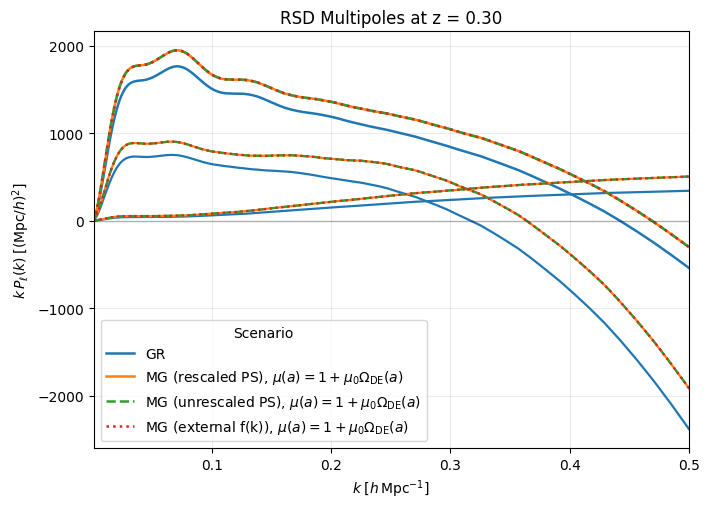

In [5]:
# ==========================
# Plot multipoles for GR + 3 MG variants
# ==========================
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

series = [
    ("GR",                  "C0", "-",  k_GR,            P0_GR,            P2_GR,            P4_GR),
    ("MG (rescaled PS), $\mu(a)=1+\mu_0\Omega_\mathrm{DE}(a)$",    "C1", "-",  k_MG_internal,   P0_MG_internal,   P2_MG_internal,   P4_MG_internal),
    ("MG (unrescaled PS), $\mu(a)=1+\mu_0\Omega_\mathrm{DE}(a)$",  "C2", "--", k_MG_unrescaled, P0_MG_unrescaled, P2_MG_unrescaled, P4_MG_unrescaled),
    ("MG (external f(k)), $\mu(a)=1+\mu_0\Omega_\mathrm{DE}(a)$",  "C3", ":",  k_MG,            P0_MG,            P2_MG,            P4_MG),
]

fig, ax = plt.subplots(figsize=(7.2, 5.2))

# plot: same style per scenario; label only once per scenario
for label, color, ls, kk, P0, P2, P4 in series:
    ax.plot(kk, kk*P0, linestyle=ls, color=color, linewidth=1.8, label=label)  # ℓ=0 (carries legend label)
    ax.plot(kk, kk*P2, linestyle=ls, color=color, linewidth=1.6)               # ℓ=2
    ax.plot(kk, kk*P4, linestyle=ls, color=color, linewidth=1.6)               # ℓ=4

# legend: scenarios only
ax.legend(title="Scenario", loc="best")

ax.set_xlabel(r"$k\;[h\,\mathrm{Mpc}^{-1}]$")
ax.set_ylabel(r"$k\,P_\ell(k)\;[(\mathrm{Mpc}/h)^2]$")
ax.set_title(f"RSD Multipoles at z = {z_pk:.2f}")

ax.set_xlim(base["kmin"], base["kmax"])
ax.axhline(0, color='k', alpha=0.25, lw=1.0)

# ax.set_xscale('log')  # optional
ax.grid(True, alpha=0.25)
plt.tight_layout()
plt.show()

# Test 2: Verify results agree in the GR limit

In [6]:
# --- ISiTGR setup: cosmology + redshift grid for finite-difference f(k,z) ---
pars = isitgr.CAMBparams()
pars.set_cosmology(H0=h*100, ombh2=ombh2, omch2=omch2, mnu=93.14*omnuh2,
                   MG_parameterization="muSigma", mu0=0.0)
pars.InitPower.set_params(As=As, ns=ns)

# finite-difference step in ln a around z_pk
dln_a = 1e-3
a0 = 1.0/(1.0 + z_pk)
a1 = a0 * np.exp(-dln_a)
a2 = a0 * np.exp(+dln_a)
z1 = 1.0/a1 - 1.0
z2 = 1.0/a2 - 1.0

# include z=0 because your f_of_k uses P(z=0,k) for normalization
z_list = sorted([z1, z_pk, z2, 0.0])
pars.set_matter_power(redshifts=z_list, kmax=2.0)
pars.NonLinear = model.NonLinear_none

# --- run ISiTGR as you already do (with z_list including z1, z_pk, z2, 0.0) ---
results = isitgr.get_results(pars)

# 1) Use the cached interpolator to get the internal k-grid and P_lin(k,z_pk)
PK, z_nodes, ks = results.get_matter_power_interpolator(
    nonlinear=False, hubble_units=True, k_hunit=True, return_z_k=True, silent=True
)
pk_lin = PK.P(z_pk, ks)        # shape (nk_internal,)

# 2) f(k,z_pk) uses the same internal k-grid (ks)
kh_fk, fk_lin = results.f_of_k(z_pk, hubble_units=True, k_hunit=True)
# sanity: these should now match exactly
assert np.allclose(kh_fk, ks)

# 3) large-scale limit f0 (choose your small-k cut)
smallk = ks < 3e-3
f0 = float(np.mean(fk_lin[smallk])) if np.any(smallk) else float(fk_lin[0])

Note: redshifts have been re-sorted (earliest first)


In [7]:
# ==========================
# GR multipoles: using ISiTGR in the GR limit
# ==========================

# ---- pyfkpt: build FKPT tables in memory & get RSD multipoles ----
# Preferred: pass tables in-memory. If your installed pyfkpt lacks `tables=...`,
# we fall back to a TemporaryDirectory (auto-deleted).
params = dict(
    z=z_pk, Om=Om, h=h,
    b1=b1, b2=b2, bs2=bs2, b3nl=b3nl,
    alpha0=alpha0, alpha2=alpha2, alpha4=alpha4, ctilde=ctilde,
    PshotP=pshotp, alpha0shot=alpha0shot, alpha2shot=alpha2shot,
    kmin=float(max(1e-3, ks.min())), kmax=min(float(ks.max()), 0.5),
    Nk=min(ks.size, 240),
    nquadSteps=300, chatty=0, model="LCDM", fR0=1e-15,
)

# compute FKPT tables (no files)
tables = pyfkpt.compute_multipoles(k=ks, pk=pk_lin, **params)

# evaluate multipoles (ℓ=0,2,4) without AP
k_eval = np.asarray(tables["k"], float)
k_eval = k_eval[(k_eval > 0) & (k_eval <= params["kmax"])]

k_GR, P0_GR, P2_GR, P4_GR = pyfkpt.rsd_multipoles(k=k_eval, nuis=nuis, z=z_pk, Om=Om, ap=False, tables=tables)

print("GR done")

# ==========================
# MG multipoles: three variants
# ==========================

# Base FKPT params (shared)
base = dict(
    z=z_pk, Om=Om, h=h,
    b1=b1, b2=b2, bs2=bs2, b3nl=b3nl,
    alpha0=alpha0, alpha2=alpha2, alpha4=alpha4, ctilde=ctilde,
    PshotP=pshotp, alpha0shot=alpha0shot, alpha2shot=alpha2shot,
    kmin=float(max(1e-3, ks.min())),
    kmax=float(min(ks.max(), 0.5)),
    Nk=int(min(ks.size, 240)),
    nquadSteps=300, chatty=0,
    model="HDKI",    # must match models.c
    mg_variant="mu_OmDE",
    mu0=0.0
)

# evaluation grid
k_eval = np.linspace(base["kmin"], base["kmax"], base["Nk"])

# -------------------------
# (3) MG (unrescaled PS, external f from ISiTGR)
# -------------------------
p_GR_limit = deepcopy(base); p_GR_limit["rescale_PS"] = False
tables_MG = pyfkpt.compute_multipoles(k=ks, pk=pk_lin, fk=fk_lin, f0=float(f0), **p_GR_limit)
k_MG, P0_MG, P2_MG, P4_MG = pyfkpt.rsd_multipoles(
    k=k_eval, nuis=nuis, z=z_pk, Om=Om, ap=False, tables=tables_MG
)

GR done


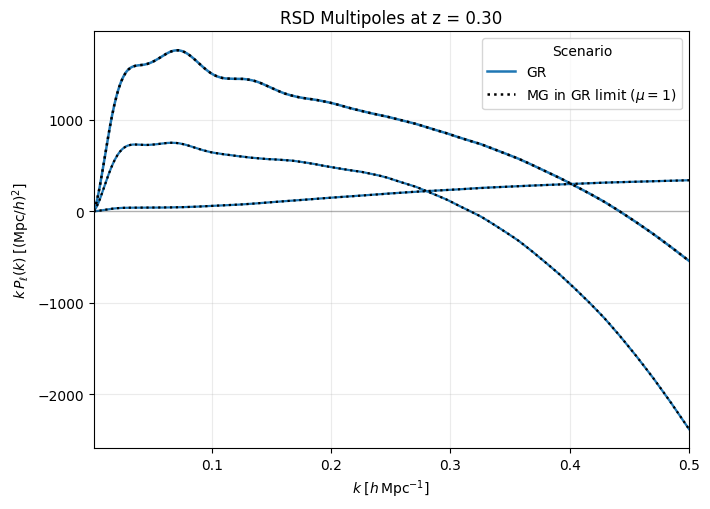

In [8]:
# ==========================
# Plot multipoles for GR + 3 MG variants
# ==========================
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

series = [
    ("GR",                  "C0", "-",  k_GR,            P0_GR,            P2_GR,            P4_GR),
    ("MG in GR limit ($\mu=1$)",  "k", ":",  k_MG,            P0_MG,            P2_MG,            P4_MG),
]

fig, ax = plt.subplots(figsize=(7.2, 5.2))

# plot: same style per scenario; label only once per scenario
for label, color, ls, kk, P0, P2, P4 in series:
    ax.plot(kk, kk*P0, linestyle=ls, color=color, linewidth=1.8, label=label)  # ℓ=0 (carries legend label)
    ax.plot(kk, kk*P2, linestyle=ls, color=color, linewidth=1.6)               # ℓ=2
    ax.plot(kk, kk*P4, linestyle=ls, color=color, linewidth=1.6)               # ℓ=4

# legend: scenarios only
ax.legend(title="Scenario", loc="best")

ax.set_xlabel(r"$k\;[h\,\mathrm{Mpc}^{-1}]$")
ax.set_ylabel(r"$k\,P_\ell(k)\;[(\mathrm{Mpc}/h)^2]$")
ax.set_title(f"RSD Multipoles at z = {z_pk:.2f}")

ax.set_xlim(base["kmin"], base["kmax"])
ax.axhline(0, color='k', alpha=0.25, lw=1.0)

# ax.set_xscale('log')  # optional
ax.grid(True, alpha=0.25)
plt.tight_layout()
plt.show()

# Test 3: Test $\mu(a) = 1 + \mu_0 \Omega_\mathrm{DE}(a)$ with and withouth EdS kernels

In [9]:
# --- ISiTGR setup: MG results ---
mu0=0.5
pars = isitgr.CAMBparams()
pars.set_cosmology(H0=h*100, ombh2=ombh2, omch2=omch2, mnu=93.14*omnuh2,
                   MG_parameterization="muSigma", mu0=mu0)
pars.InitPower.set_params(As=As, ns=ns)

# finite-difference step in ln a around z_pk
dln_a = 1e-3
a0 = 1.0/(1.0 + z_pk)
a1 = a0 * np.exp(-dln_a)
a2 = a0 * np.exp(+dln_a)
z1 = 1.0/a1 - 1.0
z2 = 1.0/a2 - 1.0

# include z=0 because your f_of_k uses P(z=0,k) for normalization
z_list = sorted([z1, z_pk, z2, 0.0])
pars.set_matter_power(redshifts=z_list, kmax=2.0)
pars.NonLinear = model.NonLinear_none

# --- run ISiTGR as you already do (with z_list including z1, z_pk, z2, 0.0) ---
results = isitgr.get_results(pars)

# 1) Use the cached interpolator to get the internal k-grid and P_lin(k,z_pk)
PK, _, ks = results.get_matter_power_interpolator(
    nonlinear=False, hubble_units=True, k_hunit=True, return_z_k=True, silent=True
)
pk_lin = PK.P(z_pk, ks)        # shape (nk_internal,)

# 2) f(k,z_pk) uses the same internal k-grid (ks)
kh_fk, fk_lin = results.f_of_k(z_pk, hubble_units=True, k_hunit=True)
# sanity: these should now match exactly
assert np.allclose(kh_fk, ks)

# 3) large-scale limit f0 (choose your small-k cut)
smallk = ks < 3e-3
f0 = float(np.mean(fk_lin[smallk])) if np.any(smallk) else float(fk_lin[0])

# --- cap k to 0.3 h/Mpc everywhere ---
KMAX = 0.3

# restrict to k <= 0.3
mask = ks <= KMAX
ks_cut   = ks[mask]
pk_cut   = pk_lin[mask]
fk_cut   = fk_lin[mask]

# large-scale limit f0 computed on the cut grid (unchanged logic)
smallk = ks_cut < 3e-3
f0 = float(np.mean(fk_cut[smallk])) if np.any(smallk) else float(fk_cut[0])

# Base FKPT params (share)
base = dict(
    z=z_pk, Om=Om, h=h,
    b1=b1, b2=b2, bs2=bs2, b3nl=b3nl,
    alpha0=alpha0, alpha2=alpha2, alpha4=alpha4, ctilde=ctilde,
    PshotP=pshotp, alpha0shot=alpha0shot, alpha2shot=alpha2shot,
    kmin=float(max(1e-3, ks_cut.min())),
    kmax=float(min(ks_cut.max(), KMAX)),
    Nk=int(min(ks_cut.size, 240)),
    nquadSteps=300, chatty=0,
    model="HDKI",
    mg_variant="mu_OmDE",
    mu0=mu0,
)

# evaluation grid stays within [kmin, 0.3]
k_eval = np.linspace(base["kmin"], base["kmax"], base["Nk"])

# ==========================
# (4) MG (unrescaled PS, external f(k), EdS kernels)
# ==========================
p_EdS = deepcopy(base)
p_EdS["rescale_PS"] = False
p_EdS["use_beyond_eds_kernels"] = False
tables_MG_EdS = pyfkpt.compute_multipoles(k=ks_cut, pk=pk_cut, fk=fk_cut, f0=f0, **p_EdS)
k_MG_EdS, P0_MG_EdS, P2_MG_EdS, P4_MG_EdS = pyfkpt.rsd_multipoles(
    k=k_eval, nuis=nuis, z=z_pk, Om=Om, ap=False, tables=tables_MG_EdS
)

# ==========================
# (5) MG (unrescaled PS, external f(k), beyond-EdS kernels)
# ==========================
p_bEdS = deepcopy(base)
p_bEdS["rescale_PS"] = False
p_bEdS["use_beyond_eds_kernels"] = True
tables_MG_beyond = pyfkpt.compute_multipoles(k=ks_cut, pk=pk_cut, fk=fk_cut, f0=f0, **p_bEdS)
k_MG_beyond, P0_MG_beyond, P2_MG_beyond, P4_MG_beyond = pyfkpt.rsd_multipoles(
    k=k_eval, nuis=nuis, z=z_pk, Om=Om, ap=False, tables=tables_MG_beyond
)

Note: redshifts have been re-sorted (earliest first)


/tmp/ipykernel_1764543/392489809.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


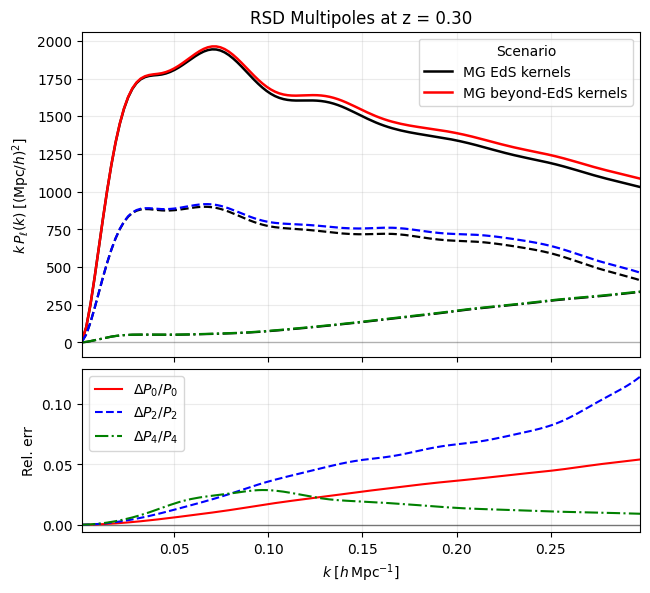

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# ==========================
# Plot multipoles for GR + EdS vs beyond-EdS MG
# ==========================

series = [
    ("MG EdS kernels",        "k", "-",  k_MG_EdS,    P0_MG_EdS,    P2_MG_EdS,    P4_MG_EdS),
    ("MG beyond-EdS kernels", "r", "--", k_MG_beyond, P0_MG_beyond, P2_MG_beyond, P4_MG_beyond),
]

# Use EdS as reference for relative error
ref_P0 = P0_MG_EdS
ref_P2 = P2_MG_EdS
ref_P4 = P4_MG_EdS
ref_k  = k_MG_EdS

# Compute relative errors for beyond-EdS
rel_err_0 = (P0_MG_beyond - ref_P0) / ref_P0
rel_err_2 = (P2_MG_beyond - ref_P2) / ref_P2
rel_err_4 = (P4_MG_beyond - ref_P4) / ref_P4

fig, (ax_main, ax_sub) = plt.subplots(
    2, 1, figsize=(7.2, 6.5), sharex=True,
    gridspec_kw={"height_ratios": [2, 1], "hspace": 0.05}
)

# ======================
# Main panel
# ======================
for label, color, ls, kk, P0, P2, P4 in series:
    # monopole
    ax_main.plot(kk, kk*P0, linestyle='-', color='red' if 'beyond' in label else 'k',
                 linewidth=1.8, label=label)
    # quadrupole
    ax_main.plot(kk, kk*P2, linestyle='--', color='blue' if 'beyond' in label else 'k',
                 linewidth=1.6)
    # hexadecapole
    ax_main.plot(kk, kk*P4, linestyle='-.', color='green' if 'beyond' in label else 'k',
                 linewidth=1.6)

ax_main.legend(title="Scenario", loc="best")
ax_main.set_ylabel(r"$k\,P_\ell(k)\;[(\mathrm{Mpc}/h)^2]$")
ax_main.set_title(f"RSD Multipoles at z = {z_pk:.2f}")
ax_main.axhline(0, color='k', alpha=0.25, lw=1.0)
ax_main.grid(True, alpha=0.25)
ax_main.set_xlim(base["kmin"], base["kmax"])

# ======================
# Lower subpanel (relative errors)
# ======================
ax_sub.axhline(0, color='k', lw=1.0, alpha=0.5)
ax_sub.plot(ref_k, rel_err_0, 'r-',  label=r"$\Delta P_0/P_0$")
ax_sub.plot(ref_k, rel_err_2, 'b--', label=r"$\Delta P_2/P_2$")
ax_sub.plot(ref_k, rel_err_4, 'g-.', label=r"$\Delta P_4/P_4$")
ax_sub.set_xlabel(r"$k\;[h\,\mathrm{Mpc}^{-1}]$")
ax_sub.set_ylabel("Rel. err")
ax_sub.grid(True, alpha=0.25)
ax_sub.legend(loc="best")

plt.tight_layout()
plt.show()